# Simulación Numérica del Secado Convectivo de *Ulva stenophylla*

#### Discretización mediante Diferencias Finitas Explícitas (FTCS)

Primero importamos las librerías y funciones a utilizar:

In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import erf, erfc

Definimos los parametros de difusión y convección, dimensionales y condiciones de humedad:

In [73]:
# Parámetros de Difusión y Convección
D = 1.4e-7    # Difusividad efectiva (m^2/s)
km = 2.7e-5     # Coeficiente de transferencia de masa (m/s)

# Parámetros Dimensionales
W = 2   # Espesor de Modelación (mm) 

# Condiciones de Humedad 
X0 = 0.92         # Humedad inicial uniforme
C_aire = 0.005    # Humedad del aire seco del horno 

Para la humedad en la interfase alga-aire (Ce), se calculó la humedad de equilibrio aplicando la siguiente fórmula: $$Ce = a_w \frac{P_{vs}(T_{L/2})}{R_v T_{L/2}}$$

In [74]:
# Parámetros Termodinámicos
aw = 1.0       # Actividad de agua 
R_v = 461.52   # Constante de gas vapor de agua (J/(kg*K))
T_L2 = 393.15   # Temperatura de la superficie (K)

# Coeficientes para el cálculo de Pvs
A = -5.8e3
B = 1.391
C = -4.864e-2
D = 4.176e-5
E = -1.445e-8
F = 6.545

# Cálculo de Pvs (Pascales)
ln_Pvs = (A / T_L2) + B + (C * T_L2) + (D * T_L2**2) + (E * T_L2**3) + (F * np.log(T_L2))
p_vs = np.exp(ln_Pvs) 

# Cálculo de la concentración de equilirbio (Ce = C_L/2)
Ce = (aw * p_vs) / (R_v * T_L2)  # kg/m³

Definimos la malla espacial, el espaciamiento temporal sujeto a la condición de estabilidad y la condición inicial:

In [75]:
# Definición de la Malla Espacial
N_z = 50       # Número de nodos
dz = W / N_z      # Espaciamiento del reticulado 

# Inicializar el reticulado 
z = np.linspace(0, W, N_z + 1) 

# Definición del Tiempo y Paso Temporal
t_f = 1800.0      # Tiempo final de simulación 
t = 0.0           # Tiempo inicial

# Cálculo de dt basado en la estabilidad r <= 0.45
r_max = 0.45
dt = r_max * (dz**2) / D 

# Condición Inicial
X_old = np.ones(N_z + 1) * X0 # Vector de humedad al tiempo t
print(dt)

17.24137931034483


Definimos las dimensiones, nodos y condiciones de bordes:

In [76]:
# Definición de las dimensiones
N = N_z 
N_nodes = N + 1

A = np.zeros([N_nodes, N_nodes])

# Nodos interiores (i=1 hasta N-1)
for i in range(1, N):
    # Coeficientes del nodo de la izquierda (i-1)
    A[i, i-1] = D / (dz**2)
    
    # Coeficientes del nodo central (i)
    A[i, i] = -2 * D / (dz**2)
        
    # Coeficientes del nodo a la derecha (i + 1)
    A[i, i+1] = D / (dz**2)

# Condición de borde de simetría (i=0)
A[0, 0] = -2 * D / (dz**2)
A[0, 1] = 2 * D / (dz**2)

# Condición de borde en la interfaz interfaz (i=N)
A[N, N-1] = D / (dz**2)
A[N, N] = - D / (dz**2)

Realizamos las iteraciones y guardamos los perfiles de concentración:

In [77]:
# Tiempo inicial de integración (s)
t = 0.0

# Tiempo final de integración (s)
t_max = 3600*8

# Grabamos los resultados cada 1 s
write_interval = 4800

# Lista en que se acumulan los tiempos donde se graban los perfiles de concentración
t_vec = []

# Generamos una copia de la temperatura
X_num = []

# Indice del último nodo
N_z = A.shape[0] - 1 

# Generamos el vector b dle termino convectivo
b = np.zeros(N_z + 1)
Termino_Convectivo_Borde = -km / dz * (Ce - C_aire)
b[N_z] = Termino_Convectivo_Borde

# Bucle temporal (t = 0 hasta t_max)

# Guardar el perfil inicial (t=0)
X_num.append(X_old.copy())
t_vec.append(t)

while t < t_max:
    # Iteración de nuevas humedades usando la forma matricial explícita:
    X_new = X_old + (np.dot(A, X_old) + b) * dt
    
    # Actualización y avance temporal
    t += dt
    # Preparamos el vector para la siguiente iteración
    X_old = np.copy(X_new)
    
    # Guardamos el perfil de humedad y el tiempo para poder graficar
    if (t % write_interval) < 0.9 * dt: 
        X_num.append(X_new.copy()) 
        t_vec.append(t)

Graficamos los resultados:

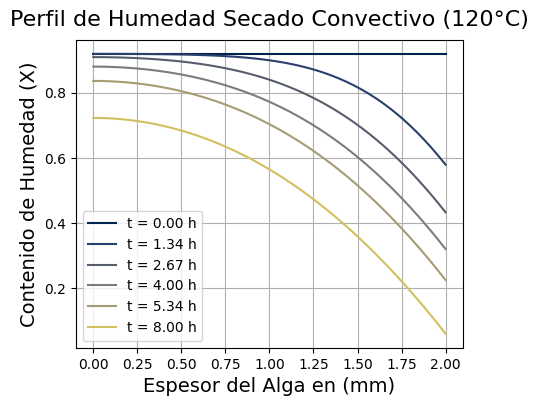

In [78]:
fig, ax = plt.subplots(1, 1, figsize = [5,4])
n_temp = len(X_num)
cividis = plt.colormaps.get_cmap("cividis")
colour = [cividis(i/n_temp) for i in range(n_temp)]

for k in range(len(X_num)):
    plt.plot(z, X_num[k], color = colour[k], label = "t = %.2f h" % (t_vec[k] / 3600.0))

plt.xlabel('Espesor del Alga en (mm)', size = 14)
plt.ylabel('Contenido de Humedad (X)', size = 14)
ax.set_title('Perfil de Humedad Secado Convectivo (120°C)', size=16, pad=10)
plt.grid()
plt.legend()
plt.show()

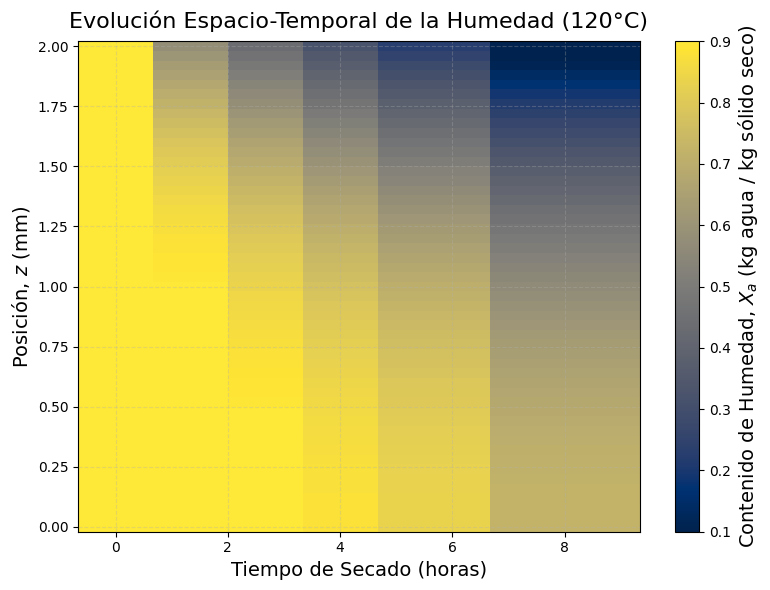

In [ ]:
X_matrix = np.array(X_num)

t_horas = np.array(t_vec) / 3600.0

z_mm = np.array(z) 

fig, ax = plt.subplots(1, 1, figsize=[8, 6]) 

c = ax.pcolormesh(t_horas, z_mm, X_matrix.T, cmap='cividis', shading='auto', vmin=0.1, vmax=0.9) 

ax.set_title('Evolución Espacio-Temporal de la Humedad (120°C)', size=16, pad=10)
ax.set_xlabel('Tiempo de Secado (horas)', size=14)
ax.set_ylabel('Posición, $z$ (mm)', size=14)

cbar = fig.colorbar(c, ax=ax, orientation='vertical')
cbar.set_label('Contenido de Humedad, $X_a$ (kg agua / kg sólido seco)', size=14)

ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()